## Initiate Project

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

RSEED = 42

In [2]:
# Read data
df_tanzania=pd.read_csv("data/Train.csv")

In [3]:
# As our target is TZN money, function to have custom format to make the plots more readable. 
def thousands_formatter(x, pos):
    return f'{int(x):,}'

In [4]:
df_continents = pd.read_csv('data/continents.csv')
df_continents.columns = df_continents.columns.str.lower()

In [5]:
df_tanzania = pd.merge(df_tanzania, df_continents[['country', 'region_1',"continent"]], on='country', how='left')

In [6]:
# Transform columns to "total nights" and "total people"
df_tanzania["total_nights"] = df_tanzania["night_mainland"] + df_tanzania["night_zanzibar"]
df_tanzania["total_people"] = df_tanzania["total_male"] + df_tanzania["total_female"]

In [7]:
# Create the new column with bins
df_tanzania['trip_category'] = pd.cut(
    df_tanzania['total_people'],
    bins=[0, 1, 2, 5,float('inf')],  # Define the bin edges
    labels=['Alone', 'Couple', 'Family', 'Group', ],  # Labels for each bin
    right=True ) 

Text(0.5, 1.0, 'Total Cost by Trip Category')

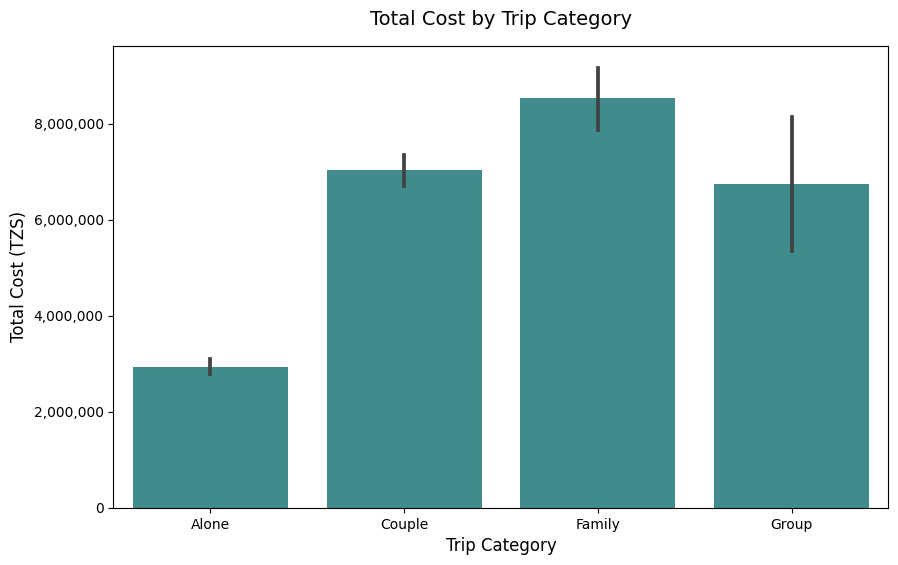

In [23]:

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(df_tanzania, x="trip_category", y="total_cost", color = "teal", alpha = 0.8)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))


ax1.set_ylabel("Total Cost (TZS)", fontsize=12)
ax1.set_xlabel("Trip Category", fontsize=12)
ax1.tick_params(axis='x', rotation=0)
ax1.set_title("Total Cost by Trip Category", fontsize=14, pad=15)

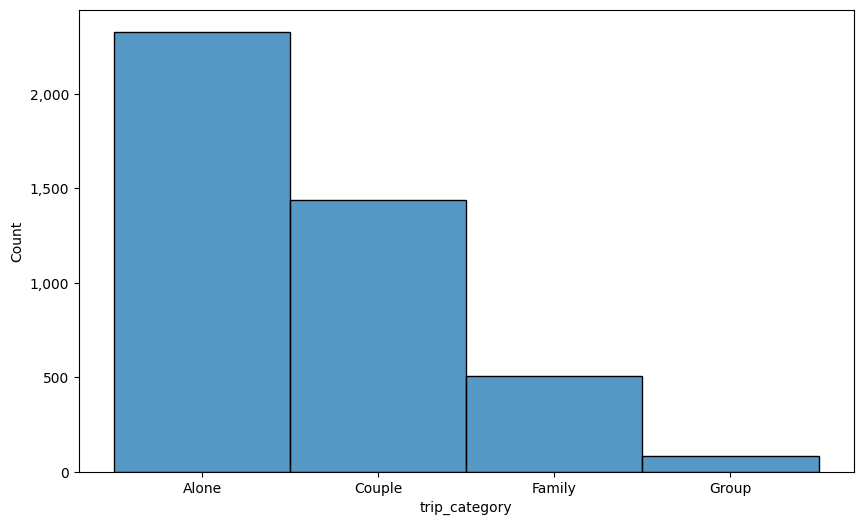

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.histplot(df_tanzania["trip_category"])
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

## Evaluate Target 

In [9]:
df_tanzania.shape

(4809, 28)

In [10]:
df_tanzania.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost', 'region_1', 'continent', 'total_nights', 'total_people',
       'trip_category'],
      dtype='object')

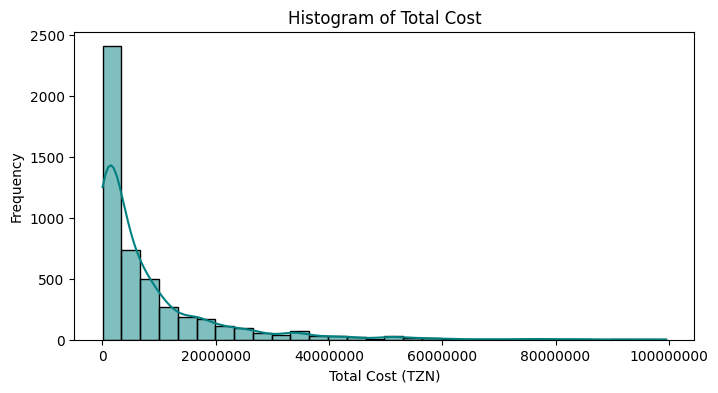

In [11]:
# Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_tanzania["total_cost"], bins=30, kde=True, color='teal')
plt.title('Histogram of Total Cost')
plt.xlabel('Total Cost (TZN)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain')
plt.show()

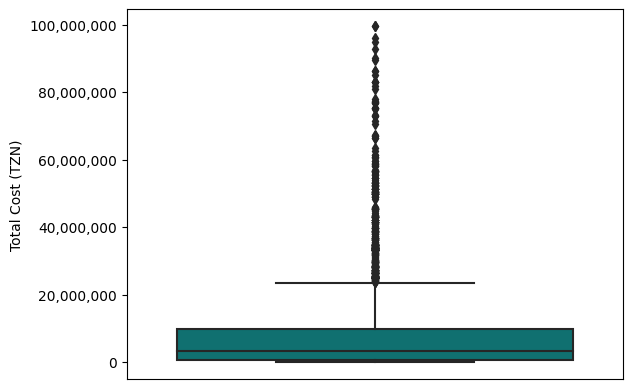

In [12]:
# Plotting the boxplot
sns.boxplot(df_tanzania["total_cost"], color="teal")
plt.xticks([])  # Removes the x-axis ticks


# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZN)")

# Display the plot
plt.show()

In [13]:
# Define function to print the whiskers of a boxplot

def calculate_whiskers(df, column):
    """
    Calculate the lower and upper whiskers for a specified column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to calculate whiskers for.

    Returns:
        tuple: (lower_whisker, upper_whisker)
    """
    # Get descriptive statistics for the column
    stats = df[column].describe()
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1

    # Calculate the lower whisker
    lower_whisker = max(
        df[column][df[column] >= (Q1 - 1.5 * IQR)].min(), 
        df[column].min()
    )
    
    # Calculate the upper whisker
    upper_whisker = min(
        df[column][df[column] <= (Q3 + 1.5 * IQR)].max(), 
        df[column].max()
    )
    
    return lower_whisker, upper_whisker

In [14]:
lower, upper = calculate_whiskers(df_tanzania, "total_cost")
print("Upper Whisker total cost", upper)

Upper Whisker total cost 23635950.0


In [15]:
#Remove outliers
df_tanzania = df_tanzania.query("total_cost <= 23635950.0")

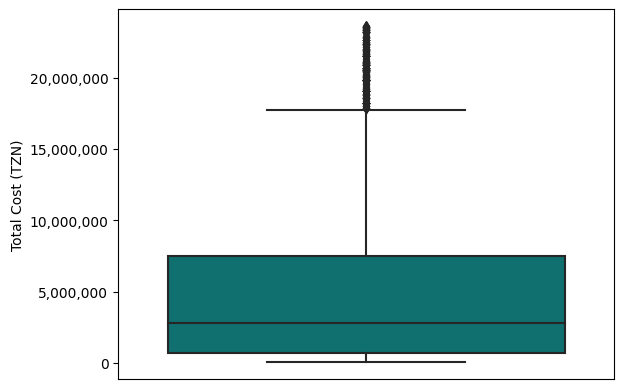

In [16]:
# Plotting the boxplot
sns.boxplot(df_tanzania["total_cost"], color="teal")
plt.xticks([])  # Removes the x-axis ticks
# 
# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZN)")

# Display the plot
plt.show()

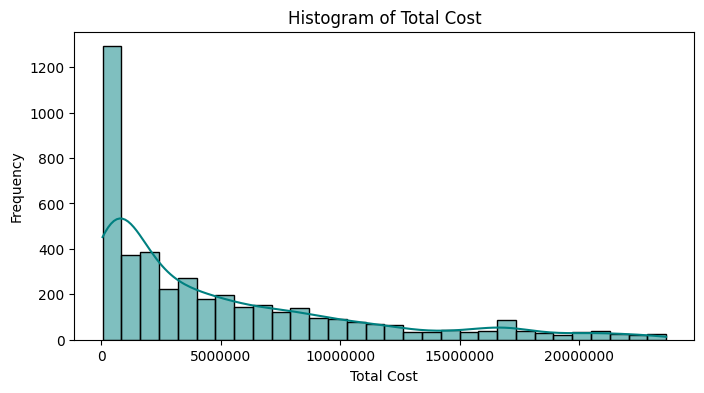

In [17]:
# Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_tanzania["total_cost"], bins=30, kde=True, color='teal')
plt.title('Histogram of Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain')
plt.show()

## Train-Test Split

In [18]:
# split train-test data. We have dropped:
# Decision to drop also all numerical features, as we do not see correlation, plus other features that don't seem to have an impact on the final cost

X = df_tanzania.drop(['total_cost','ID', "most_impressing", "main_activity", "region_1","country",'total_female','total_male',"total_people", 'night_mainland', 'night_zanzibar','payment_mode','info_source','purpose','travel_with'],axis=1)
y = df_tanzania.total_cost

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=RSEED)
# Build new data frame for EDA

df_tanzania_train = X_train.join(y_train)
df_tanzania_test = X_test.join(y_test)

## Initial Feature Engineering

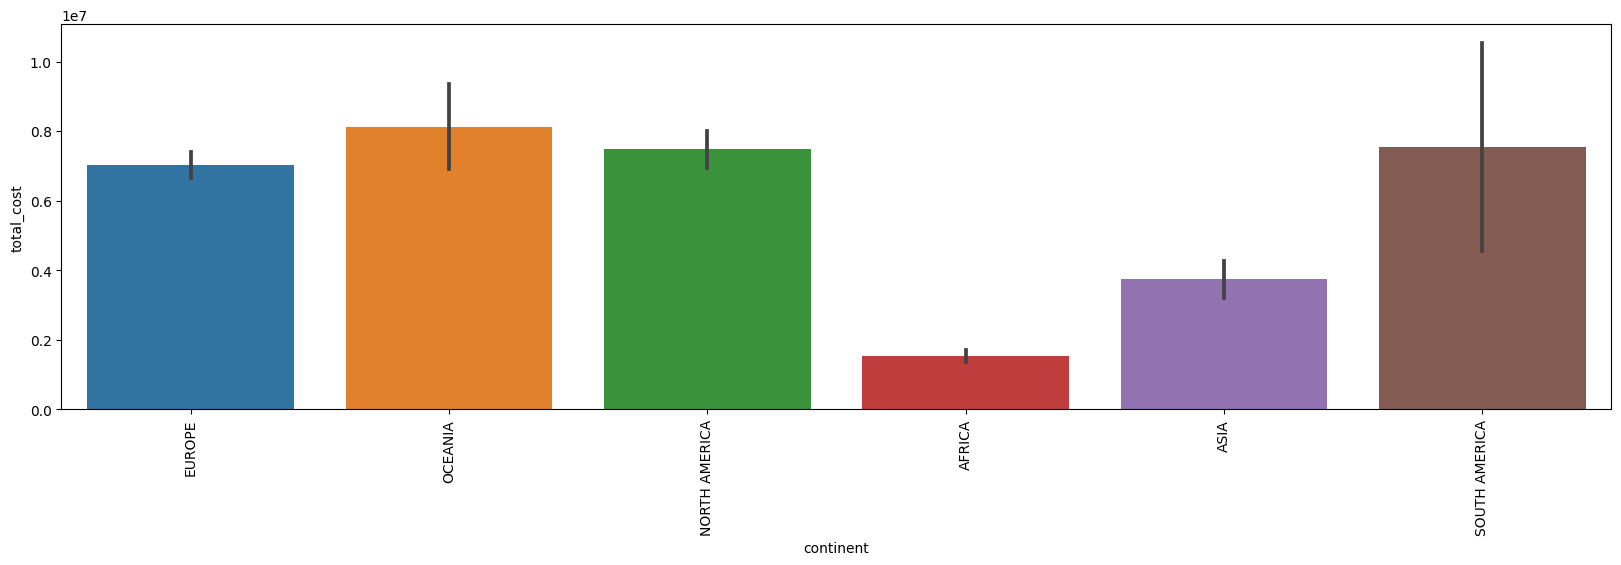

In [161]:
# Sort the DataFrame by 'total_cost' in descending order
df_tanzania_sorted = df_tanzania_train.sort_values(by="total_cost", ascending=False)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(y=df_tanzania_sorted["total_cost"], x=df_tanzania_sorted["continent"], ax=ax)
plt.xticks(rotation=90)

plt.show()

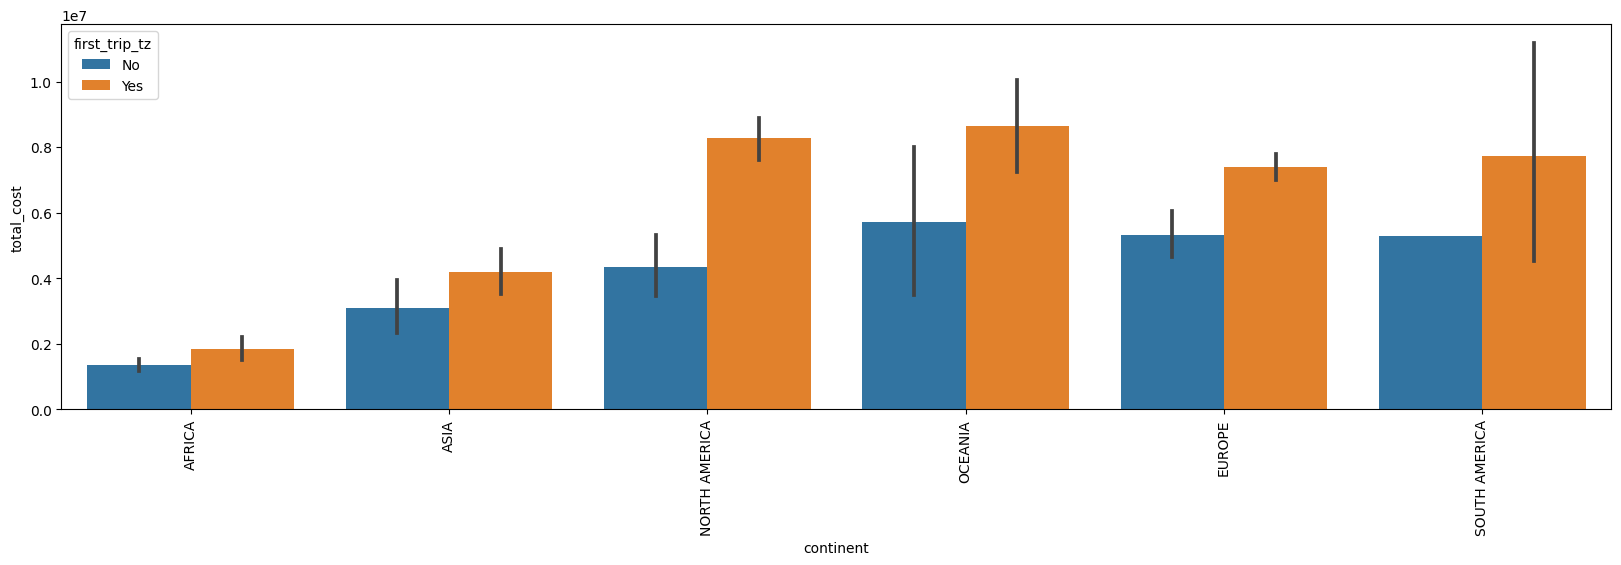

In [162]:
# Create the plot
df_tanzania_sorted = df_tanzania_train.sort_values(by="total_cost", ascending=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(y=df_tanzania_sorted["total_cost"], x=df_tanzania_sorted["continent"], hue = df_tanzania_sorted["first_trip_tz"], ax=ax)
plt.xticks(rotation=90)

plt.show()

(array([0, 1, 2, 3]),
 [Text(0, 0, '25-44'),
  Text(1, 0, '45-64'),
  Text(2, 0, '65+'),
  Text(3, 0, '1-24')])

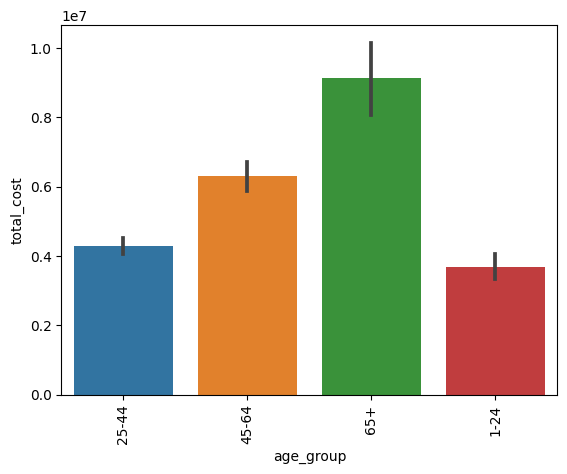

In [163]:
sns.barplot(df_tanzania_train, x="age_group", y="total_cost")
plt.xticks(rotation=90)

([0, 1, 2, 3],
 [Text(0, 0, '25-44'),
  Text(1, 0, '45-64'),
  Text(2, 0, '65+'),
  Text(3, 0, '1-24')])

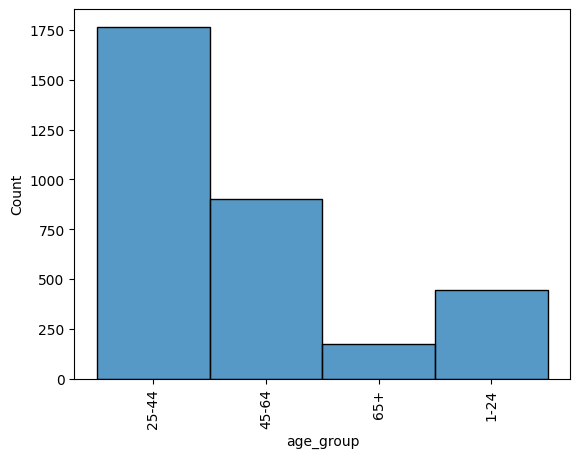

In [164]:
sns.histplot(df_tanzania_train["age_group"])
plt.xticks(rotation=90)


In [165]:
df_tanzania_train.columns

Index(['age_group', 'tour_arrangement', 'package_transport_int',
       'package_accomodation', 'package_food', 'package_transport_tz',
       'package_sightseeing', 'package_guided_tour', 'package_insurance',
       'first_trip_tz', 'continent', 'total_nights', 'trip_category',
       'total_cost'],
      dtype='object')

In [166]:
# # Create the plot
# df_tanzania_sorted = df_tanzania_train.sort_values(by="total_cost", ascending=True)
# sns.barplot(df_tanzania_train, x="main_activity", y="total_cost")
# plt.xticks(rotation=90)


In [167]:
# sns.barplot(df_tanzania_train, x="total_people", y="total_cost")
# plt.xticks(rotation=90)

In [168]:
# sns.histplot(df_tanzania["total_people"])

In [169]:
# sns.boxplot(df_tanzania,y="total_people")

In [170]:
# lower, upper = calculate_whiskers(df_tanzania, "total_people")
print("Upper Whisker total people", upper)

Upper Whisker total people 23635950.0


In [171]:
df_tanzania.shape

(4385, 28)

In [172]:
# df_tanzania = df_tanzania.query("total_people <= 15")

In [173]:
df_tanzania.shape

(4385, 28)

In [174]:
# sns.boxplot(df_tanzania,y="total_people")

In [175]:
# sns.barplot(df_tanzania, x="total_people", y="total_cost")
# # plt.xticks(rotation=90)

In [176]:
# df_tanzania_sorted = df_tanzania.sort_values(by="total_people", ascending=False)

# sns.barplot(df_tanzania, x="total_people", y="total_cost")
# plt.xticks(rotation=90)

## EDA

In [177]:
df_tanzania_train.columns

Index(['age_group', 'tour_arrangement', 'package_transport_int',
       'package_accomodation', 'package_food', 'package_transport_tz',
       'package_sightseeing', 'package_guided_tour', 'package_insurance',
       'first_trip_tz', 'continent', 'total_nights', 'trip_category',
       'total_cost'],
      dtype='object')

In [178]:
# Check for empty values. We have them in "total_female", "total_male" and mostly in "travel_with"

df_tanzania_train.isnull().sum()

age_group                  0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
first_trip_tz              0
continent                522
total_nights               0
trip_category             15
total_cost                 0
dtype: int64

In [179]:
# most of our features are categorical, besides four of them: 
# total_female, total_male, night_mainland, night_zanzibar and the total cost

df_tanzania_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3288 entries, 4428 to 958
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age_group              3288 non-null   object  
 1   tour_arrangement       3288 non-null   object  
 2   package_transport_int  3288 non-null   object  
 3   package_accomodation   3288 non-null   object  
 4   package_food           3288 non-null   object  
 5   package_transport_tz   3288 non-null   object  
 6   package_sightseeing    3288 non-null   object  
 7   package_guided_tour    3288 non-null   object  
 8   package_insurance      3288 non-null   object  
 9   first_trip_tz          3288 non-null   object  
 10  continent              2766 non-null   object  
 11  total_nights           3288 non-null   float64 
 12  trip_category          3273 non-null   category
 13  total_cost             3288 non-null   float64 
dtypes: category(1), float64(2), object(11)
memo

## Some Plots

In [180]:
# sns.barplot(df_tanzania_train, x="main_activity", y="total_cost")
# plt.xticks(rotation=90)

In [181]:
# sns.histplot(df_tanzania["main_activity"])

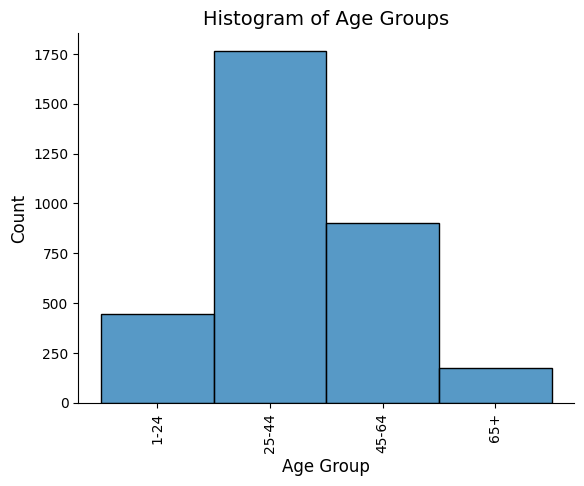

In [182]:
# <Reorganize the age_group and make it categorical

custom_order = ['1-24', '25-44', '45-64', "65+"] 


# Convert 'age_group' into a categorical variable with the custom order
df_tanzania_train['age_group'] = pd.Categorical(
    df_tanzania_train['age_group'], 
    categories=custom_order, 
    ordered=True
)

# Plot the histogram
sns.histplot(data=df_tanzania_train, x='age_group', stat='count', palette="viridis")

# Aesthetics
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Age Groups", fontsize=14)
plt.xticks(rotation=90)
sns.despine()


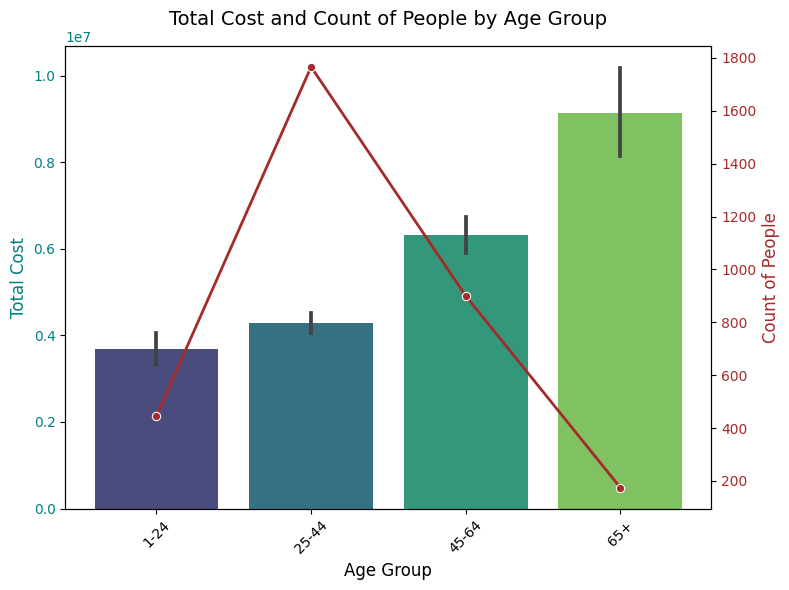

In [183]:
# Group by age_group to calculate total cost and counts
grouped = df_tanzania_train.groupby('age_group').agg(
    total_cost=('total_cost', 'sum'),
    count=('total_cost', 'count')
).reindex(['1-24', '25-44', '45-64', "65+"])  # Ensure custom order

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart for total cost
sns.barplot(x=df_tanzania_train.age_group, y=df_tanzania_train.total_cost, ax=ax1, palette="viridis")
ax1.set_ylabel("Total Cost", fontsize=12, color="teal")
ax1.set_xlabel("Age Group", fontsize=12)
ax1.tick_params(axis='y', labelcolor="teal")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Total Cost and Count of People by Age Group", fontsize=14, pad=15)

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the line chart for the count of people
sns.lineplot(x=grouped.index, y=grouped['count'], ax=ax2, color="brown", marker="o", linewidth=2)
ax2.set_ylabel("Count of People", fontsize=12, color="brown")
ax2.tick_params(axis='y', labelcolor="brown")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Feature Engineering - Train

## Imputation

In [184]:
# Impute empty values of "total_female" with rounded mean. 
# Impute empty values of "total_male" with rounded mean. 

# df_tanzania_train['total_people'].fillna(round(df_tanzania_train['total_people'].mean()), inplace=True)

### Encoding

In [185]:
#List of columns
col_encode = ['age_group', "trip_category", 'tour_arrangement',"continent"]
col_map = ['package_transport_int', 'package_accomodation', 'package_food','package_transport_tz', 'package_sightseeing', 'package_guided_tour','package_insurance','first_trip_tz',]
col_scale = ["total_nights"]

In [186]:
# Mapp all Yes/No features (col_map)

def mapping_tanzania(df,cols):
    df[cols] = df[cols].replace({'Yes': 1, 'No': 0}) 

mapping_tanzania(df_tanzania_train,col_map)

In [187]:
# Scale all numerical features (col_scale)
scaler = MinMaxScaler()
scaler.fit(df_tanzania_train[col_scale])
df_tanzania_train[col_scale] = scaler.transform(df_tanzania_train[col_scale])

In [188]:
# Encode all categorical features (col_encode)
categories = [df_tanzania_train[col].unique() for col in col_encode]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_train[col_encode]) 
t = ohe.transform(df_tanzania_train[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_train_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_encode], axis=1)
df_tanzania_train.drop(columns=col_encode,inplace=True)

In [189]:
df_tanzania_train.shape

(3288, 24)

### Encoding - Pipeline / ColumnTransformer (WiP)

In [190]:
# # Custom transformer for `travel_with`
# class TravelWithTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         # Apply the logic for `travel_with` as described
#         X = X.copy()
#         for index, row in X.iterrows():
#             if pd.isnull(row['travel_with']):
#                 male = row['total_male']
#                 female = row['total_female']
#                 if male == 1 and female == 0:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 elif male == 0 and female == 1:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 else:
#                     X.at[index, 'travel_with'] = 'Unknown'
#         return X[['travel_with']]

#     def get_feature_names_out(self, input_features=None):
#         # Return the output column name for `travel_with`
#         return ['travel_with']

In [191]:
# # Custom imputer transformer to round the mean
# class RoundedMeanImputer(TransformerMixin, BaseEstimator):
#     def fit(self, X, y=None):
#         self.means_ = X.mean().round()
#         return self

#     def transform(self, X):
#         return X.fillna(self.means_)
    
#     def get_feature_names_out(self, input_features=None):
#         # Return the same feature names as the input
#         return input_features

In [192]:
# # ColumnTransformer with RoundedMeanImputer
# preprocessor = ColumnTransformer(
#     transformers=[
#         # Custom imputer for total_female and total_male using rounded mean
#         ('impute_num', RoundedMeanImputer(), ['total_female', 'total_male']),
        
#         # Map Yes/No features to 1/0 directly
#         ('map_binary', OneHotEncoder(drop='if_binary', sparse=False), col_map),

#         # Custom transformer for travel_with
#         ('custom_travel_with', TravelWithTransformer(), ['travel_with', 'total_male', 'total_female']),
        
#         # One-hot encode categorical features
#         ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), col_encode),
        
#         # Scale numerical features
#         ('scale', MinMaxScaler(), col_scale)
#     ],
#     remainder='passthrough'  # Keeps any columns not explicitly listed
# )

# # Full pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor)
# ])


In [193]:
# # Fit and transform the data
# df_processed = pipeline.fit_transform(df_tanzania_train)

# # Convert to DataFrame
# output_columns = pipeline.named_steps['preprocessor'].get_feature_names_out()
# df_processed = pd.DataFrame(df_processed, columns=output_columns)

# # Verify results
# print("Shape of processed DataFrame:", df_processed.shape)
# print("Remaining NaN values:", df_processed.isna().sum().sum())

## Feature Engineering - Test

## Imputation

In [194]:
# Impute empty values of "total_female" with rounded mean. 
# Impute empty values of "total_male" with rounded mean. 
# 
# df_tanzania_test['total_people'].fillna(round(df_tanzania_test['total_people'].mean()), inplace=True)

### Encoding

In [195]:
mapping_tanzania(df_tanzania_test,col_map)

In [196]:
# Encode all categorical features (col_encode)

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_test[col_encode]) 
t = ohe.transform(df_tanzania_test[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_test_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_test = pd.concat([df_tanzania_test.reset_index(drop=True), df_tanzania_test_encode], axis=1)
df_tanzania_test.drop(columns=col_encode,inplace=True)

In [197]:
# Scale all numerical features (col_scale)
scaler = MinMaxScaler()
scaler.fit(df_tanzania_test[col_scale])
df_tanzania_test[col_scale] = scaler.transform(df_tanzania_test[col_scale])

In [198]:
df_tanzania_train.shape

(3288, 24)

In [199]:
df_tanzania_test.shape

(1097, 24)

# Modeling

In [200]:
X_train = df_tanzania_train.drop("total_cost", axis=1)
y_train = df_tanzania_train["total_cost"]
X_test = df_tanzania_test.drop("total_cost", axis=1)
y_test = df_tanzania_test["total_cost"]

In [201]:
# Define a function to calculate metrics

def evaluate_model(title, model, X_test, y_test):
    """
    Evaluate a model on the test set and print the evaluation metrics.

    Parameters:
        model_name (str): The name of the model to display in the title.
        model: The trained model to evaluate.
        X_test: Test features.
        y_test: True labels for the test set.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics with a title
    print(f"{title} {model}:")
    print(f" - Mean Squared Error (MSE): {mse}")
    print(f" - Root Mean Squared Error (RMSE): {rmse}")
    print(f" - Mean Absolute Error (MAE): {mae}")
    print(f" - R-squared (R²): {r2}\n")

In [202]:
# Define a function to plot actual vs predicted cost
def plot_model_results(model_name, model, y_train, y_pred):
    plt.figure(figsize=(7, 5))
    plt.scatter(y_train, y_pred, color='teal', alpha=0.5)
    plt.plot([0, df_tanzania_train["total_cost"].max()], [0, df_tanzania_train["total_cost"].max()], color='brown', linestyle='--')  # line of perfect predictions (45-degree line)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.xlabel('Actual Values (Cost in TZN)')
    plt.ylabel('Actual Values (Cost in TZN)')
    plt.title(f'Predicted vs Actual Values: {model_name}')
    plt.show()

## Model: Random Forest

In [203]:
# # Initialize baseline model Regressor
# (max_depth=10, max_features='sqrt', min_samples_split=10, n_estimators=200, random_state=42)

model_rf_2= RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10, n_estimators=200, random_state=RSEED)
model_rf_2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      n_estimators=200, random_state=42)

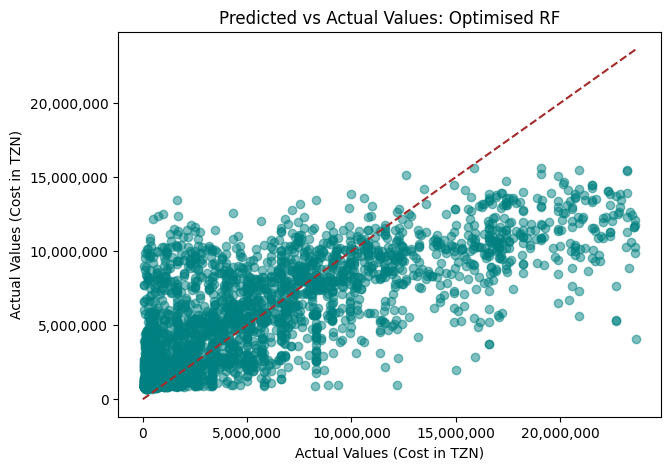

In [204]:
y_pred = model_rf_2.predict(X_train)
plot_model_results("Optimised RF", model_rf_2, y_train, y_pred)

In [206]:
evaluate_model("Train",model_rf_2, X_train, y_train)
evaluate_model("Test",model_rf_2, X_test, y_test)

Train RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      n_estimators=200, random_state=42):
 - Mean Squared Error (MSE): 13771407082141.13
 - Root Mean Squared Error (RMSE): 3710984.6512941993
 - Mean Absolute Error (MAE): 2553558.9228086253
 - R-squared (R²): 0.5643932791915791

Test RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      n_estimators=200, random_state=42):
 - Mean Squared Error (MSE): 17530334981722.764
 - Root Mean Squared Error (RMSE): 4186924.2866002205
 - Mean Absolute Error (MAE): 2813627.5323361526
 - R-squared (R²): 0.4564833975670205



## Grid Search Optimisation

In [181]:
model_rf_2= RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10, n_estimators=200, random_state=RSEED)
model_rf_2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      n_estimators=200, random_state=42)

In [182]:
param_grid = [
    { 
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 15, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "max_features":['sqrt', "log2", 2, 3, 5, 8, 10]
    }]


In [183]:

gs = GridSearchCV( 
    estimator=RandomForestRegressor(),
    param_grid= param_grid,
    cv=10,
    verbose=3, 
    error_score='raise',
    n_jobs=-1
)

#fit the model
gs.fit(X_train, y_train)

# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Fitting 10 folds for each of 945 candidates, totalling 9450 fits


KeyboardInterrupt: 

In [ ]:
model_rf_2_opt = gs.best_estimator_

In [ ]:
evaluate_model("Train",model_rf_2_opt, X_train, y_train)
evaluate_model("Test",model_rf_2_opt, X_test, y_test)

Train RandomForestRegressor(max_depth=10, max_features=8, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200):
 - Mean Squared Error (MSE): 13110614702182.096
 - Root Mean Squared Error (RMSE): 3620858.2825322086
 - Mean Absolute Error (MAE): 2431315.890493442
 - R-squared (R²): 0.584558643433973

Test RandomForestRegressor(max_depth=10, max_features=8, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200):
 - Mean Squared Error (MSE): 17702567024046.086
 - Root Mean Squared Error (RMSE): 4207441.8622300755
 - Mean Absolute Error (MAE): 2833763.2714703563
 - R-squared (R²): 0.4197348575248946



In [557]:
#this didn't change much. The previous one was actually better